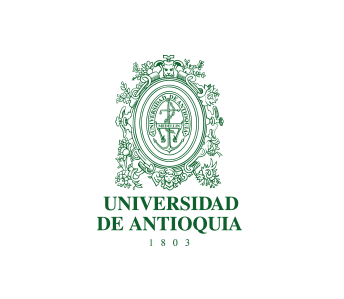

# Proyecto 3: Análisis de señales ECG y detección de arritmias - análisis espectral

Estudiantes:
- Juan Camilo Carvajal Sierra - 1010124738
- Ana María Uribe Betancur - 1000537653
- Duvan Vega Cardona - 1003896233

Objetivo:

Implementar un flujo de procesamiento que incluya filtrado de las señales y extracción de características espectrales.

In [ ]:
from scipy.stats import levene, shapiro, ttest_ind, mannwhitneyu
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt, find_peaks, freqz, detrend
import random
import scipy.signal as signal
import pywt
from statsmodels.nonparametric.smoothers_lowess import lowess
from skimage.restoration import denoise_nl_means, estimate_sigma
from statsmodels.robust import mad
import scipy.io as sio
from skimage.util import view_as_windows
from itertools import combinations

In [ ]:
file_id2 = '1IhCUZRzL8RkBqlRPpY5boBzukPkjOIqM'
destination2 = 'Diagnostics.xlsx'

!gdown --id {file_id2} --output {destination2}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IhCUZRzL8RkBqlRPpY5boBzukPkjOIqM
To: /content/Diagnostics.xlsx
100% 976k/976k [00:00<00:00, 45.3MB/s]


In [ ]:
# Se realiza la carga de archivos filtrados por los autores de la investigación al entorno
file_id = '1tGXh5G3DEOshn6DA28nioFCQv7ZX0e0l'
destination = 'ECGDataDenoised.zip'

!gdown --id {file_id} --output {destination}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1tGXh5G3DEOshn6DA28nioFCQv7ZX0e0l
From (redirected): https://drive.google.com/uc?id=1tGXh5G3DEOshn6DA28nioFCQv7ZX0e0l&confirm=t&uuid=54caa593-5fa8-4be8-8978-78040a05f3b6
To: /content/ECGDataDenoised.zip
100% 2.01G/2.01G [00:23<00:00, 85.3MB/s]


In [ ]:
# Se realiza la carga de archivos ya procesados con el flujo elegido al entorno
file_id = '1-O0calvKB3ulHeUvyS3rDWpXVsOyzSV3'
destination = 'ECGDataDenoisedNew.zip'

!gdown --id {file_id} --output {destination}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-O0calvKB3ulHeUvyS3rDWpXVsOyzSV3
From (redirected): https://drive.google.com/uc?id=1-O0calvKB3ulHeUvyS3rDWpXVsOyzSV3&confirm=t&uuid=1eae3a62-4527-40fb-afd0-f9c3d4c8aae2
To: /content/ECGDataDenoisedNew.zip
100% 1.43G/1.43G [00:18<00:00, 77.3MB/s]


In [ ]:
datos = pd.read_excel('Diagnostics.xlsx')
# Observación preliminar de las variables y estructura del dataset
datos.describe()

datos = pd.read_excel('Diagnostics.xlsx')
datos_filtrados = datos[datos['Rhythm'] != 'SR']
datos_2 = datos_filtrados[(datos_filtrados['PatientAge'] >= 18) & (datos_filtrados['PatientAge'] <= 90)]
datos_finales = datos_2[(datos_2['Rhythm'] != 'AVNRT') & (datos_2['Rhythm'] != 'AVRT') & (datos_2['Rhythm'] != 'SAAWR')]

In [ ]:
# Se extraen los archivos ya depurados en una carpeta dentro del entorno
import zipfile
zip_path = "ECGDataDenoisedNew.zip"
extract_to = "ecg_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [ ]:
# Se extraen los archivos en una carpeta dentro del entorno
import zipfile
zip_path = "ECGDataDenoised.zip"
extract_to = "ecg_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)



---


# **PUNTO 1.**


---


Del artículo:
https://www.nature.com/articles/s41598-020-59821-7
Consultar y explicar los dos métodos de reducción de ruido usados en el artículo: Robust LOESS y Non Local Means (10%), y como se pueden implementar en librerías conocidas de Python (5%)

### **Robust LOESS**

El algoritmo LOESS (Suavizado de gráficos de dispersión ponderados localmente) es usado como un método resistente a los valores atípicos basado en ajustes polinómicos locales. La idea básica es comenzar con un ajuste de mínimos cuadrados polinómico local,(un ajuste tipo k-NN) en cada punto de tiempo y luego forma robusta incorpora una iteración adicional: tras un primer ajuste, se calcula el residuo de cada punto y se asignan pesos menores a los outliers, repitiendo el proceso. Específicamente, uno puede primero ajustar una regresión polinómica en un vecindario de x.

Fuente: https://www.ime.unicamp.br/~dias/loess.pdf

En señales ECG, tipicamente se se presenta la deriva de línea base, inducida por movimientos respiratorios u otros artefactos de baja frecuencia (<0.5 Hz). Para tratar este tipo de ruido LOESS nos ayuda a eliminar la deriva de línea base, adaptandose localmente a las variaciones de la señal, preservando  las características morfológicas del ECG.



En python este metodo no parametrico se puede implementar usar statsmodels o sklearn con funciones personalizadas. A continuación, se presenta un ejemplo usando statsmodels:

*Importamos la libreria*
```
import statsmodels.api as sm
```
*Usamos la función "nonparametric.lowess" que nos permite variar las iteraciones para mayor robustez*
```
loess_smoothed = sm.nonparametric.lowess(y_señalECG, tiempoECG,
frac=frac,   # Proporción de datos usada para suavizar cada punto (más pequeño = más local).
it=3,       # Número de iteraciones robustas para mitigar outliers.
delta=0.01*h   # Paso para submuestreo
)
```
*Extraemos la línea base estimada*
```
baseline = loess_smoothed[:,1]
ecg_corregido = y_señalECG - baseline
```



### **Non-Local Means (NLM)**

Es un método avanzado para **reducir el ruido en imágenes digitales** al promediar píxeles similares, sin importar su cercanía espacial.

1. **Idea principal**: Reemplaza el valor de un píxel con el promedio de otros píxeles **similares en apariencia**, aunque estén lejos en la imagen. A diferencia de métodos clásicos, considera similitud estructural, no solo proximidad.

2. **Similitud entre parches**: La semejanza se evalúa comparando **parches de píxeles** alrededor de cada punto, usando la **distancia euclidiana** entre ellos. Los pesos se calculan con una función exponencial basada en esa distancia y en el nivel de ruido `σ`.

3. **Implementaciones**:

   * **Pixelwise**: Calcula un valor denoised para cada canal de color en cada píxel, usando una **ventana de búsqueda** y **parches**. Los pesos se ajustan según la similitud, y se limita el tamaño de la ventana por razones computacionales.
   * **Patchwise**: Usa la similitud entre parches para denoising de todos los píxeles dentro de un parche a la vez. Mejora el PSNR y reduce artefactos en bordes.

4. **Parámetros clave**:

   * Tamaño del parche y ventana de búsqueda dependen del ruido `σ`.
   * El parámetro de filtrado `h` se ajusta como `h = kσ`, con `k` decreciendo al aumentar el tamaño del parche.



---


# **PUNTO 2.**
---


Descargar los datos sin filtrar ECGData.zip de:  
https://figshare.com/collections/ChapmanECG/4560497/1  
De los datos sin filtrar usar los registros que se han usado para análisis en los dos trabajos previos, para permitir que se pueda comparar entre grupos. De estos registros los análisis para el presente proyecto deben hacerse en la derivación II


In [ ]:
# Se realiza la carga de archivos al entorno
file_id = '155VGZwPFACKy4qHwxsgA7d5NHnTjIMgf'
destination = 'ECGData.zip'

!gdown --id {file_id} --output {destination}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=155VGZwPFACKy4qHwxsgA7d5NHnTjIMgf
From (redirected): https://drive.google.com/uc?id=155VGZwPFACKy4qHwxsgA7d5NHnTjIMgf&confirm=t&uuid=899d55fe-58a8-488f-90ca-1cbb4daaf8e0
To: /content/ECGData.zip
100% 755M/755M [00:07<00:00, 97.1MB/s]


In [ ]:
# Importación de las señales de ECG
# Se extraen los archivos en una carpeta dentro del entorno
import zipfile
zip_path = "ECGData.zip"
extract_to = "ecg_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)



---


# **PUNTO 3.**


---


Consultar que tipos de señales wavelet se pueden usar para el análisis de señales ECG y adaptar el código del filtro wavelet que se entrega en el curso de acuerdo a la consulta (10%)

En la literatura biomédica, se destacan los siguientes tipos de wavelets:


| Wavelet                             | Características clave                                           | Adecuado para...                 |
| ----------------------------------- | --------------------------------------------------------------- | -------------------------------- |
| **Daubechies (db2, db3, ... , db10)**      | Muy usadas, buen compromiso entre suavidad y detalle            | QRS, T wave detection, denoising |
| **Symlets (sym2, ... , sym8)**            | Más simétricas que Daubechies, parecidas en forma               | Preservar forma ECG              |
| **Biorthogonal (bior1.3, ... , bior6.8)** | Simetría perfecta, útiles para reconstrucción precisa           | ECG baseline & morphology        |
| **Coiflets (coif1, ... , coif5)**         | Más momentos de anulación, buena para detalles finos            | Detección de ondas débiles       |
| **Mexican Hat, Morlet** (CWT)       | Wavelets continuas, útiles para análisis visual o QRS detection | No recomendadas para DWT básica  |

Fuente: https://biblus.us.es/bibing/proyectos/use/abreproy//fichero/11127%252FRECONOCIMIENTO+DE+IRIS%252FCapitulo+2.+TEORIA+DE+WAVELETS.pdf

Modificando el codigo dado en clase para poder elegir cualquier tipo de señal wavelet queda de la siguiente manera:



```
# Antes:
data_wavelet = pywt.wavedec(data, 'db6', level=8)
...
x_rec = pywt.waverec(coeff, 'db6')

# Después:
wavelet = 'sym4'  # <-- Cambiamos aquí para probar sym4, bior3.5, etc.
data_wavelet = pywt.wavedec(data, wavelet, level=8)
...
x_rec = pywt.waverec(coeff, wavelet)
```
Finalemente el codigo completo, realizando como ejemplo algunos tipos de señales wavelet queda de la siguiente forma:



=========== Procesando wavelet: db4 ===========


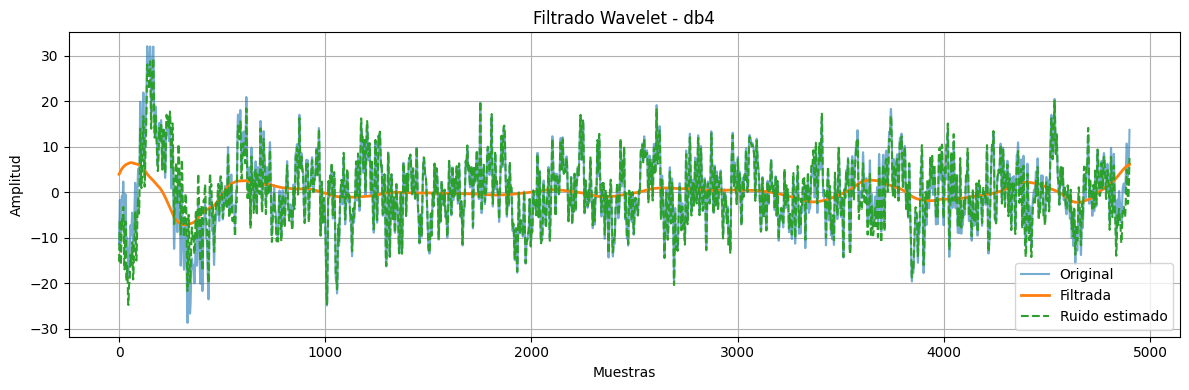


=========== Procesando wavelet: db6 ===========


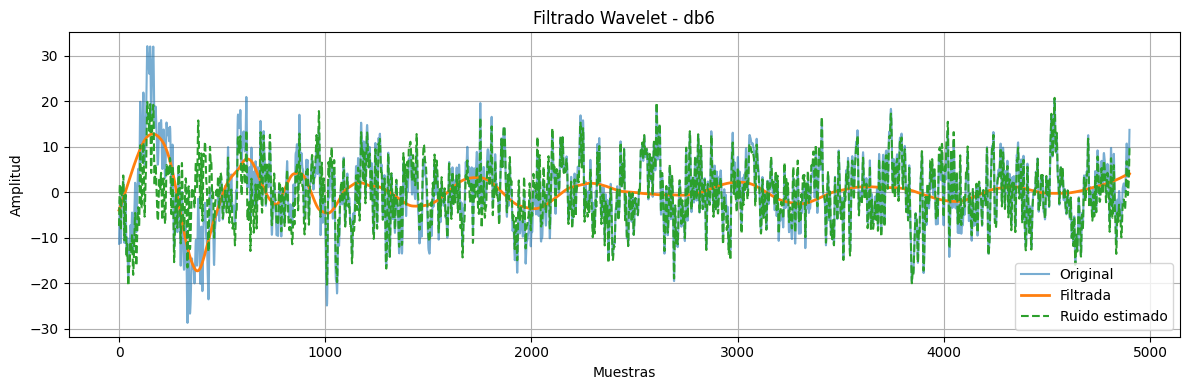


=========== Procesando wavelet: sym4 ===========


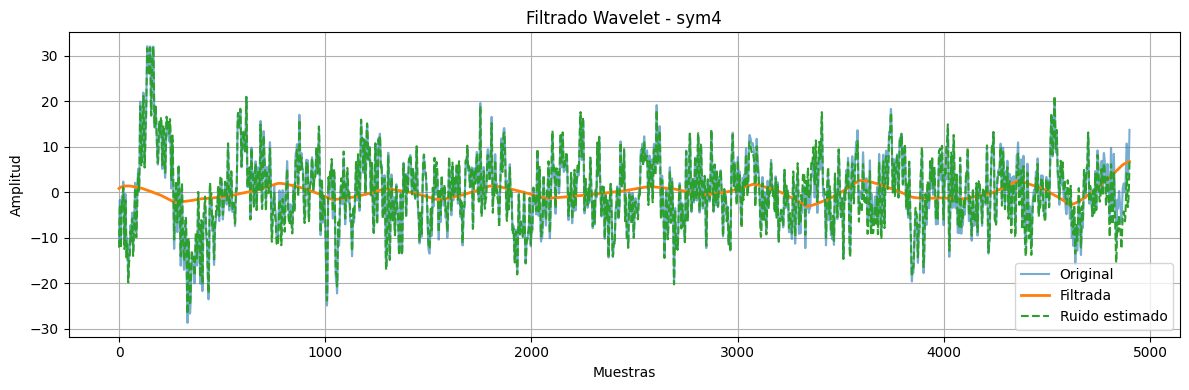


=========== Procesando wavelet: bior3.5 ===========


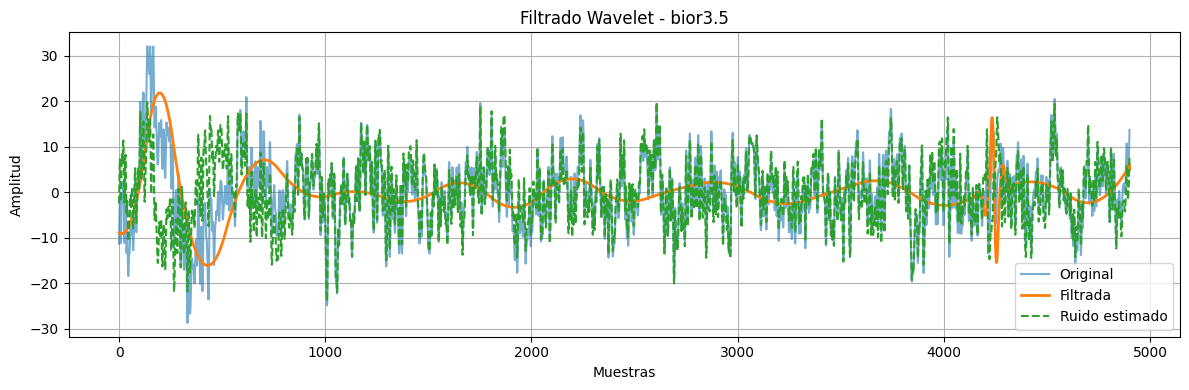


=========== Procesando wavelet: coif5 ===========


/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


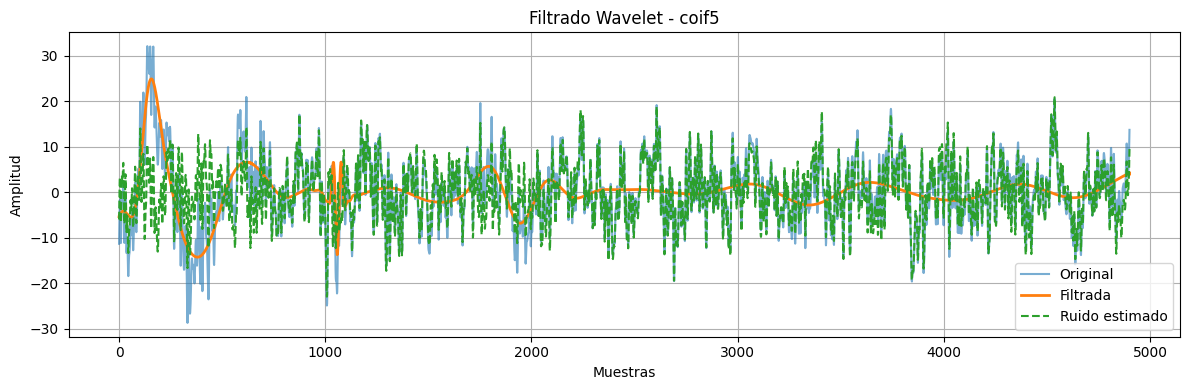

In [ ]:
# Función para estimar ruido (desviación robusta)
def wnoisest(coeff):
    stdc = np.zeros((len(coeff), 1))
    for i in range(len(coeff)):
        stdc[i] = (np.median(np.abs(coeff[i]))) / 0.6745
    return stdc

# Umbralización
def threshold(coeff):
    Num_samples = sum([len(c) for c in coeff])
    thr = np.sqrt(2 * np.log(Num_samples))
    return thr

# Aplicación de umbralización
def wthresh(coeff):
    y = list()
    s = wnoisest(coeff)
    thr = threshold(coeff)
    for i in range(len(coeff)):
        y.append(np.multiply(coeff[i], np.abs(coeff[i]) > (thr * s[i])))
    return thr, s, y

# Cargar señal ECG desde archivo .mat
mat_contents = sio.loadmat('senal_prueba_wavelet.mat')
data = np.squeeze(mat_contents['senal'])
N = len(data)

# Lista de wavelets a comparar
wavelets = ['db4', 'db6', 'sym4', 'bior3.5', 'coif5']

for wavelet in wavelets:
    print(f"\n=========== Procesando wavelet: {wavelet} ===========")

    # Descomposición wavelet
    coeffs = pywt.wavedec(data, wavelet, level=8)
    approx = coeffs[0]
    details = coeffs[1:]

    # Umbralización de los coeficientes de detalle
    thr, s, details_t = wthresh(details)

    # Reconstrucción de la señal filtrada
    coeffs_filt = [approx] + details_t
    x_rec = pywt.waverec(coeffs_filt, wavelet)
    x_rec = x_rec[:N]  # Recorte por si se extendió

    # Estimación del ruido
    x_noise = data - x_rec

    # Graficar resultados
    plt.figure(figsize=(12, 4))
    plt.plot(data, label='Original', alpha=0.6)
    plt.plot(x_rec, label='Filtrada', linewidth=2)
    plt.plot(x_noise, label='Ruido estimado', linestyle='--')
    plt.title(f'Filtrado Wavelet - {wavelet}')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

#------------ CODIGO ADAPTADO :) ------------------
# Wavelet filtering
def wavelet_denoising(signal, wavelet='db6', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    cA, cDs = coeffs[0], coeffs[1:]
    _, _, cDs_filtrados = wthresh(cDs)
    return pywt.waverec([cA] + cDs_filtrados, wavelet)[:len(signal)]
#------------ CODIGO ADAPTADO :) ------------------
# def flujo_filtrado_wavelet(ecg, wavelet='sym6', nivel=8):
#     coeff = pywt.wavedec(ecg, wavelet, level=nivel)
#     approx = coeff[0]
#     detalles = coeff[1:]
#     s = wnoisest(detalles)
#     thr = threshold(detalles)
#     detalles_filtrados = wthresh(detalles, thr, s)
#     return pywt.waverec([approx] + detalles_filtrados, wavelet)[:len(ecg)]



---


# **PUNTO 4.**
---
Escoger **10 señales al azar** y aplicar un flujo de procesamiento que conste de:

   **Flujo 1**
   - Filtro pasa-altas usando filtro **IIR** a **0.5 Hz**.  
     *Justificar la elección de parámetros.*
   - Filtro wavelet modificado del **punto 3**.
   - Filtrado pasabajas **50 Hz**.  
     *Justificar la elección de parámetros y si se usa **FIR** o **IIR**.*

In [ ]:
# --- Parámetros generales ---
fs = 500  # Frecuencia de muestreo
ruta_base = '/content/ecg_data/ECGData'

# --- Escoger 10 señales al azar del DataFrame ---
muestras = datos_finales.sample(n=10, random_state=29)
# muestras = datos_finales.sample(n=10)

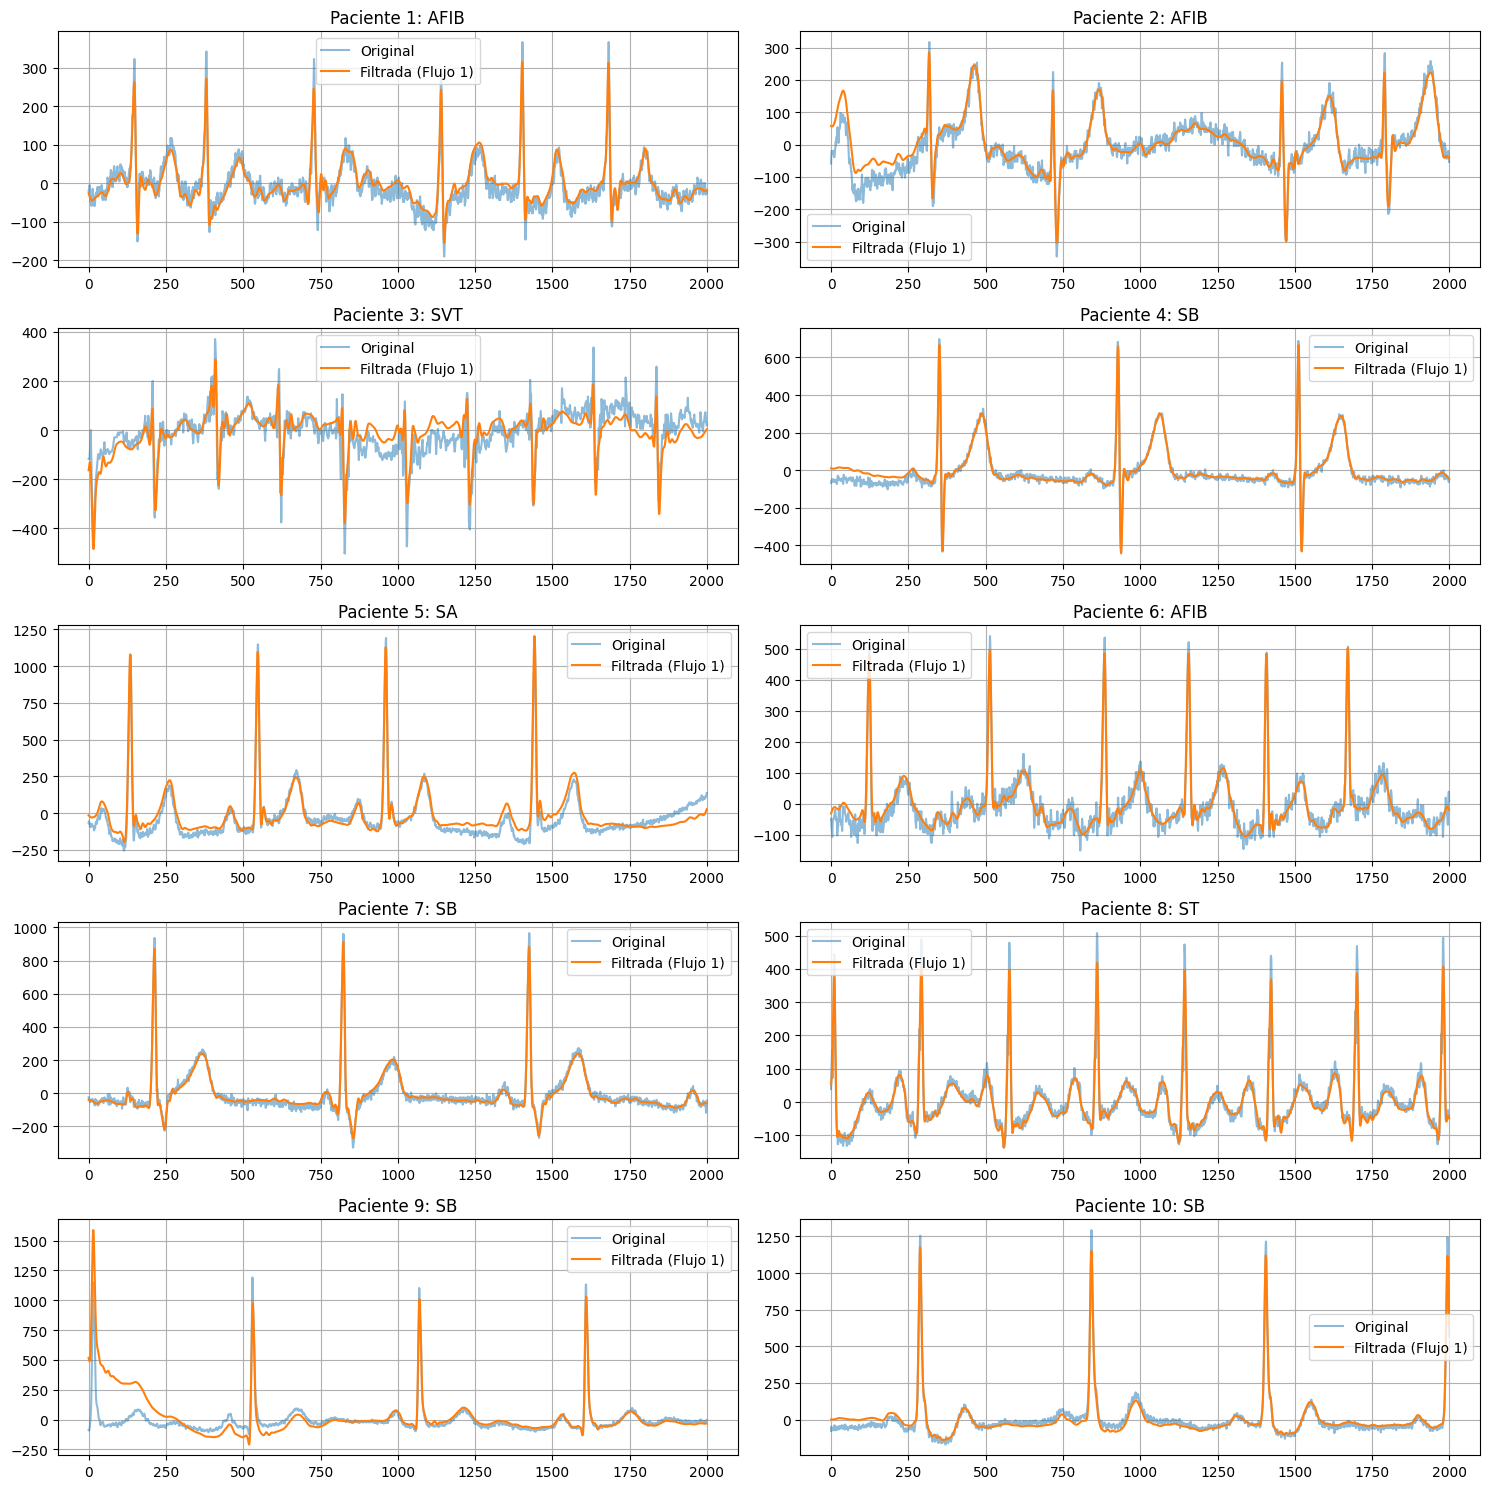

In [ ]:
# === Funciones de filtrado ===

# Filtro pasa-altas IIR (Butterworth)
def filtro_pasa_altas(data, fs, fc=0.5):
    b, a = signal.butter(N=4, Wn=fc / (fs / 2), btype='high')
    return signal.filtfilt(b, a, data)

# Filtro pasa-bajas FIR
def filtro_pasa_bajas(data, fs, fc=50):
    nyq = fs / 2
    taps = signal.firwin(numtaps=33, cutoff=fc / nyq, pass_zero="lowpass" , window='hamming')
    return signal.filtfilt(taps, [1.0], data)

# === Procesamiento y visualización ===

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for idx, row in enumerate(muestras.itertuples()):
    archivo = os.path.join(ruta_base, row.FileName) + '.csv'
    try:
        data = pd.read_csv(archivo, header=0)
        ecg = data.iloc[:, 1].values  # Derivación II

        # === Flujo 1 ===
        original = ecg

        # Paso 1: filtro pasa-altas
        filtrado1 = filtro_pasa_altas(original, fs)

        # Paso 2: filtro wavelet
        filtrado2 = wavelet_denoising(filtrado1, wavelet='db4')

        # Paso 3: filtro pasa-bajas
        final = filtro_pasa_bajas(filtrado2, fs)

        # Plot
        axes[idx].plot(original[:2000], label='Original', alpha=0.5)
        axes[idx].plot(final[:2000], label='Filtrada (Flujo 1)', linewidth=1.5)
        axes[idx].set_title(f"Paciente {idx+1}: {row.Rhythm}")
        axes[idx].legend()
        axes[idx].grid()

    except Exception as e:
        print(f"Error con el archivo {row.FileName}: {e}")

plt.tight_layout()
plt.show()

   **Flujo 2**
   - **Detrend**
   - Filtro wavelet modificado del **punto 3**.
   - Filtrado pasabajas **50 Hz**.  
     *Justificar la elección de parámetros y si se usa **FIR** o **IIR**.*

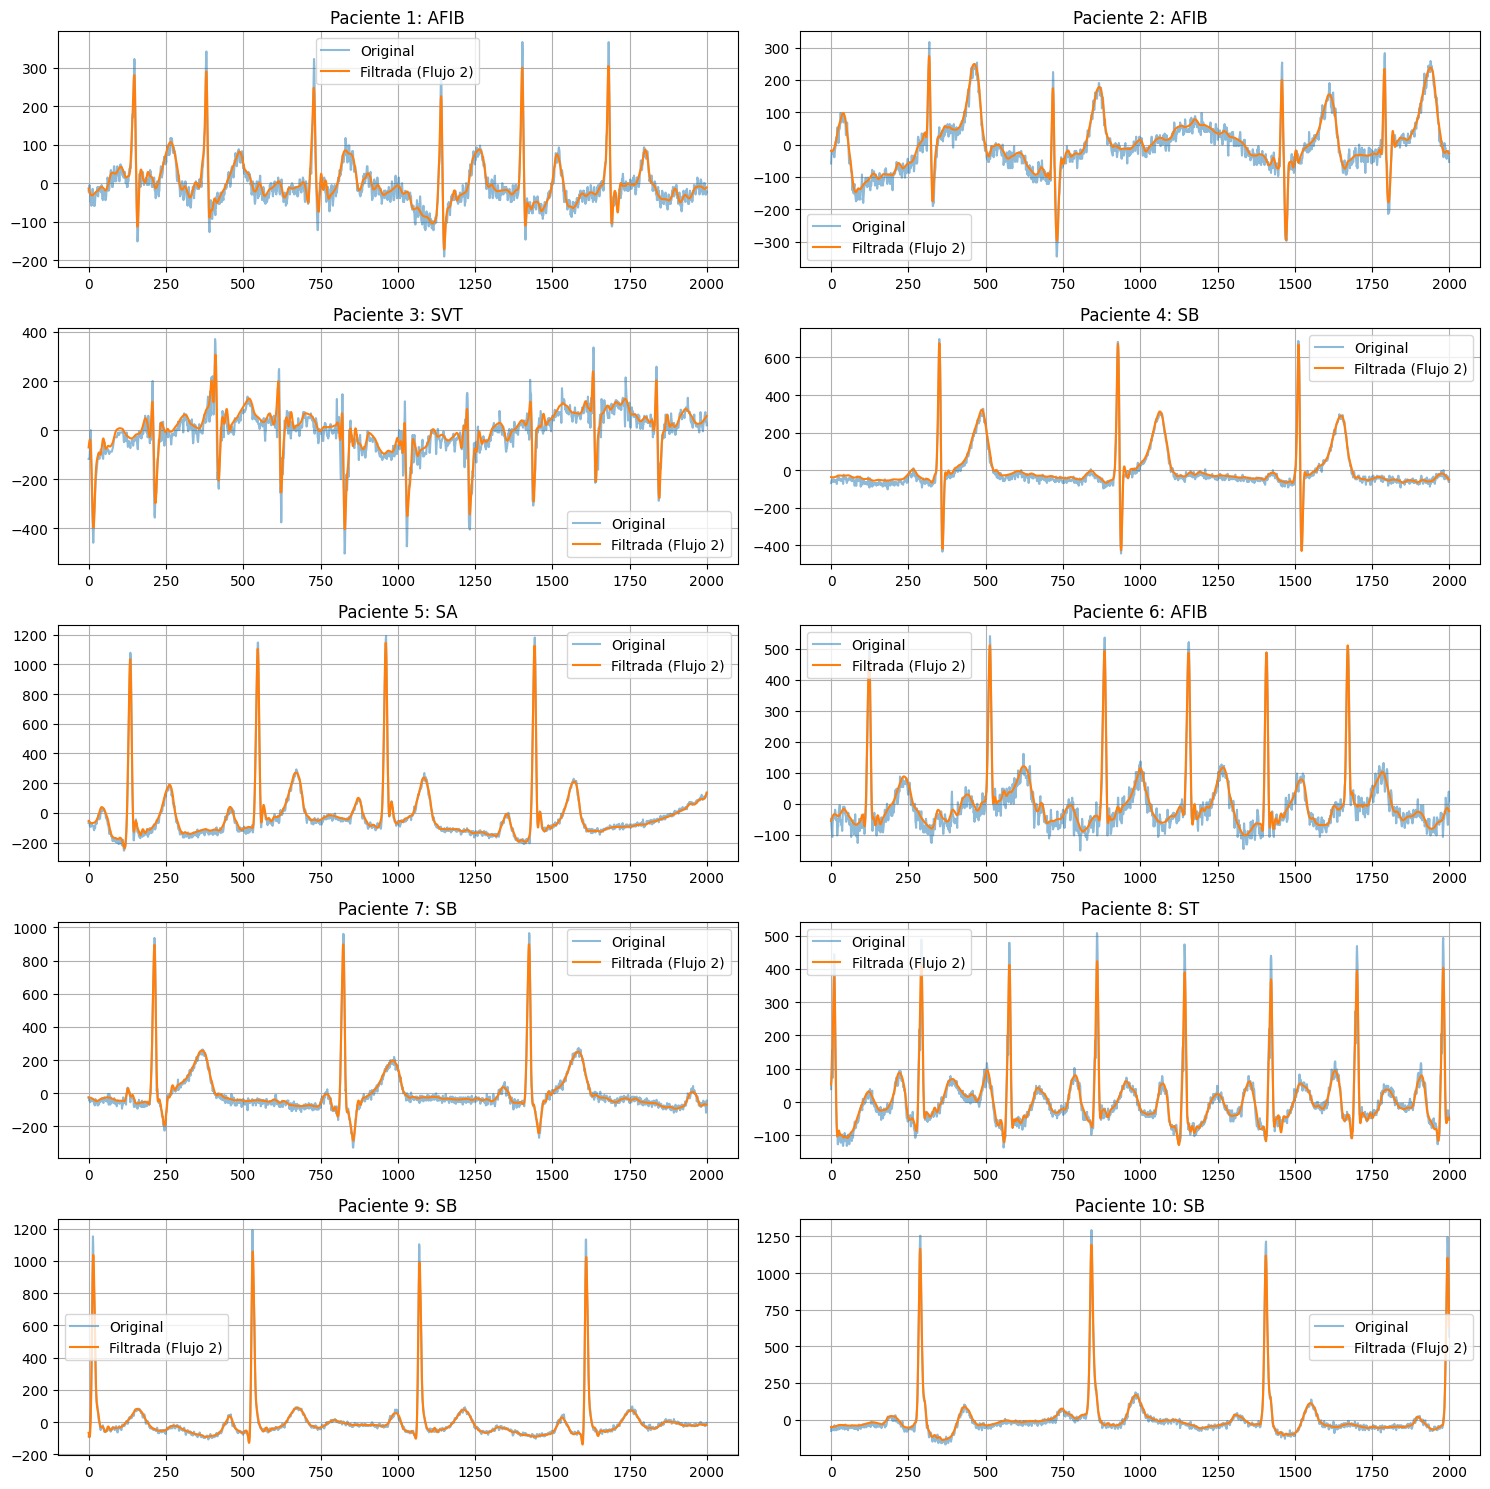

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for idx, row in enumerate(muestras.itertuples()):
    archivo = os.path.join(ruta_base, row.FileName) + '.csv'
    try:
        data = pd.read_csv(archivo, header=0)
        ecg = data.iloc[:, 1].values  # Derivación II

        # === Flujo 2 ===
        original = ecg

        # Paso 1: Detrend
        paso1 = signal.detrend(original)

        # Paso 2: Wavelet
        paso2 = wavelet_denoising(paso1, wavelet='db4')

        # Paso 3: Pasa bajas FIR (50 Hz)
        final = filtro_pasa_bajas(paso2, fs)

        # === Graficar señal original vs procesada ===
        axes[idx].plot(original[:2000], label='Original', alpha=0.5)
        axes[idx].plot(final[:2000], label='Filtrada (Flujo 2)', linewidth=1.5)
        axes[idx].set_title(f"Paciente {idx+1}: {row.Rhythm}")
        axes[idx].legend()
        axes[idx].grid()

    except Exception as e:
        print(f"Error con el archivo {row.FileName}: {e}")

plt.tight_layout()
plt.show()

   **Flujo 3**
   - Filtrado pasabajas **50 Hz**.  
     *Justificar la elección de parámetros y si se usa **FIR** o **IIR**.*
   - Filtrado **LOESS**
   - Filtrado **NLM**

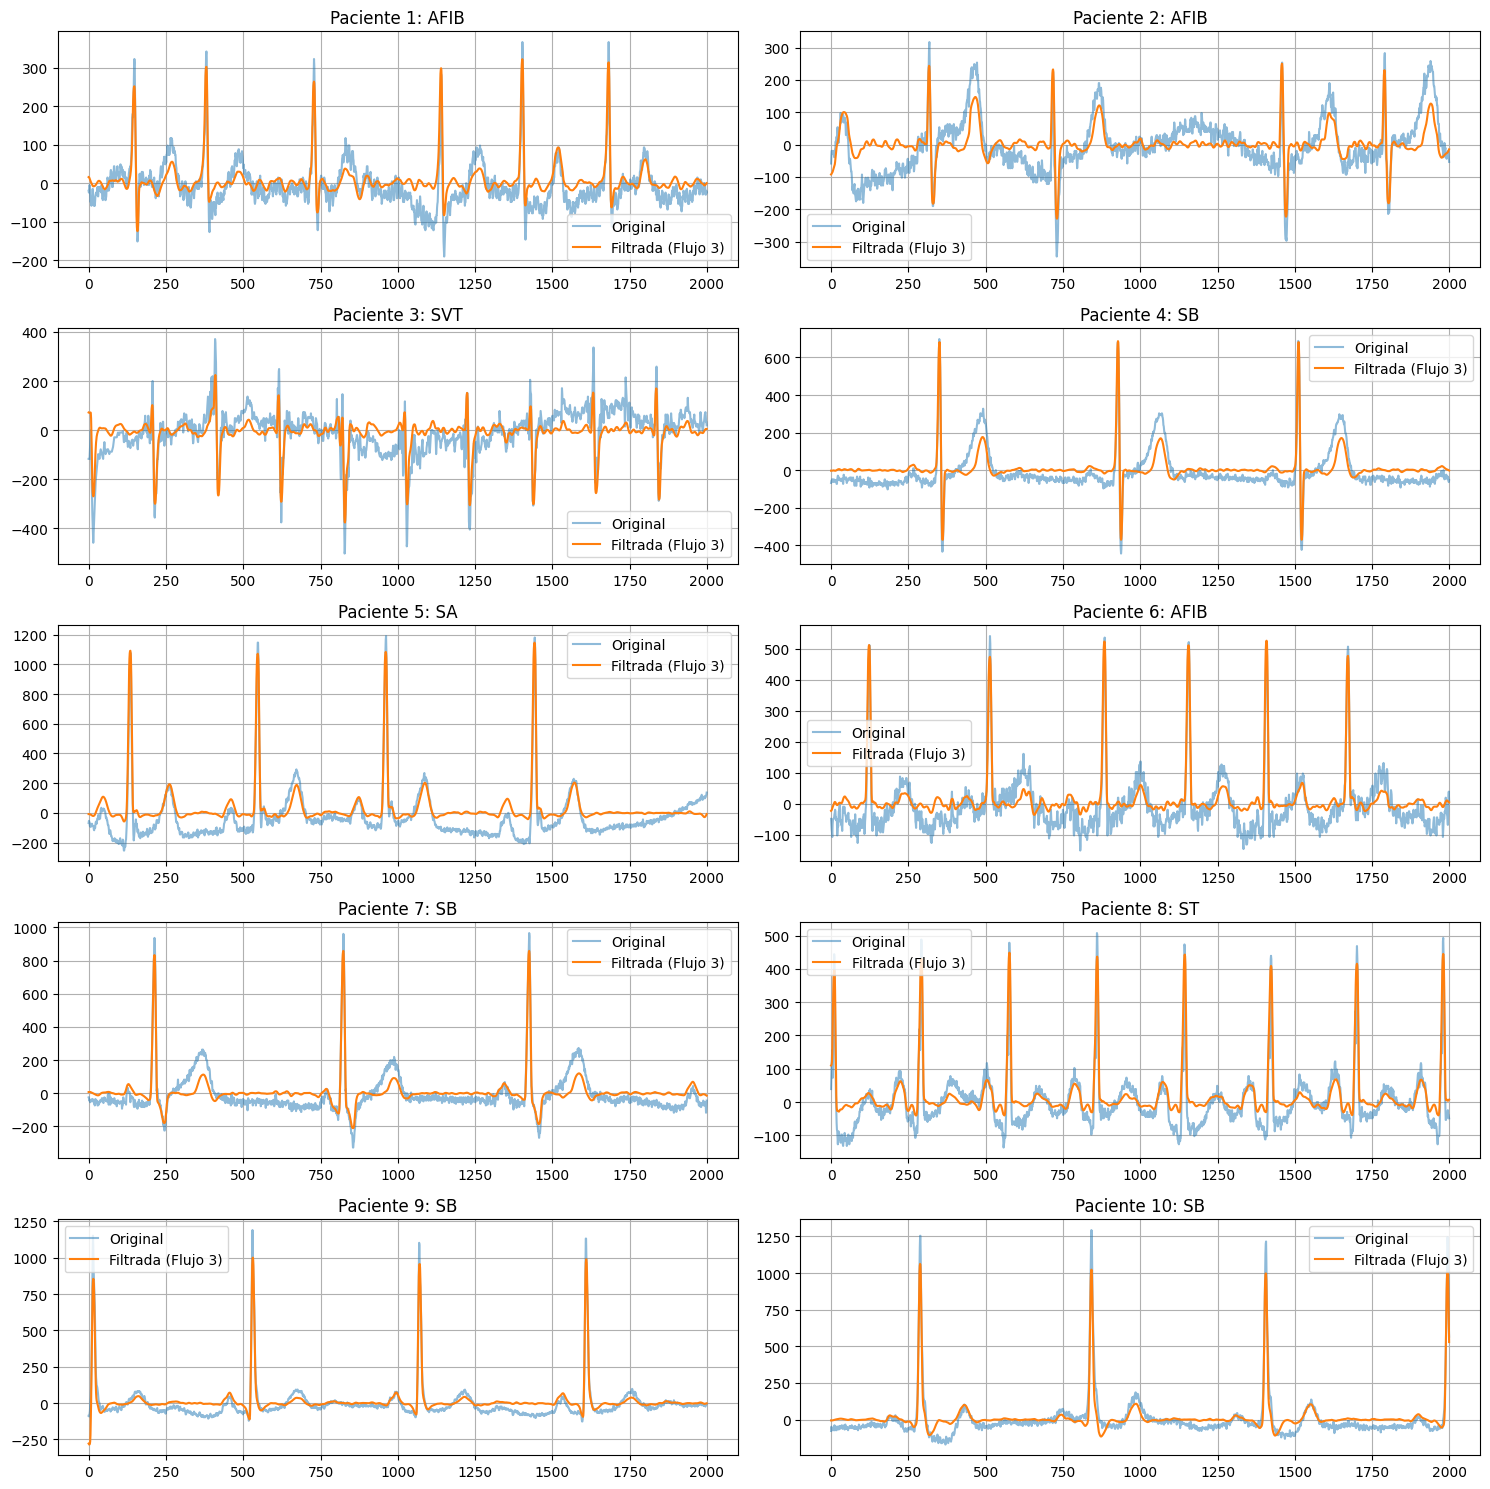

In [ ]:
# -------- Funciones Nuevas ---------
def loess_detrend(signal, frac=0.02):
    t = np.arange(len(signal))
    baseline = lowess(signal, t, frac=frac, it=3, return_sorted=False)
    return signal - baseline

def nlm_filter(signal_1d):
    # Convertir a tipo float y normalizar entre 0 y 1
    signal_norm = (signal_1d - np.min(signal_1d)) / (np.max(signal_1d) - np.min(signal_1d))

    # Expandir a 2D temporalmente (1 fila, N columnas)
    signal_2d = np.expand_dims(signal_norm, axis=0)

    # Estimar sigma del ruido
    sigma_est = np.std(signal_2d)

    # Aplicar filtro NLM 2D
    filtered_2d = denoise_nl_means(signal_2d, h=0.8 * sigma_est, fast_mode=True, patch_size=5, patch_distance=6, channel_axis=None)

    # Volver a convertir a 1D
    filtered_1d = np.squeeze(filtered_2d)

    # Restaurar escala original
    filtered_1d = filtered_1d * (np.max(signal_1d) - np.min(signal_1d)) + np.min(signal_1d)

    return filtered_1d

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for idx, row in enumerate(muestras.itertuples()):
    archivo = os.path.join(ruta_base, row.FileName) + ".csv"
    try:
        data = pd.read_csv(archivo, header=0)
        ecg = data.iloc[:, 1].values  # Derivación II

        # === Flujo 3 ===
        original = ecg

        # Paso 1: Filtro pasa-bajas (50 Hz)
        paso1 = filtro_pasa_bajas(original, fs)

        # Paso 2: LOESS
        paso2 = loess_detrend(paso1)

        # Paso 3: Non-Local Means
        final = nlm_filter(paso2)

        # === Visualización ===
        axes[idx].plot(original[:2000], label='Original', alpha=0.5)
        axes[idx].plot(final[:2000], label='Filtrada (Flujo 3)', linewidth=1.5)
        axes[idx].set_title(f"Paciente {idx+1}: {row.Rhythm}")
        axes[idx].legend()
        axes[idx].grid()

    except Exception as e:
        print(f"Error con el archivo {row.FileName}: {e}")

plt.tight_layout()
plt.show()

**Justificación:**

* *Filtro pasa-altas:* La elección del filtro Butterworth se debe a su característica de tener una respuesta de magnitud suave, sin ondulaciones en la banda de paso ni en la banda de rechazo, lo que minimiza la distorsión de la morfología de la señal ECG, especialmente de componentes clínicamente relevantes como la onda P, el complejo QRS y la onda T. Se seleccionó un filtro de cuarto orden porque proporciona una pendiente de atenuación más pronunciada entre la banda de paso y la banda de rechazo en comparación con filtros de menor orden. Esto permite una transición más abrupta, lo cual es ventajoso para atenuar eficazmente componentes de baja frecuencia como el desplazamiento de línea base (baseline wander). A su vez, este orden intermedio reduce el riesgo de distorsión de fase excesiva que puede presentarse en filtros de orden superior.

Fuente: https://www.researchgate.net/profile/Manpreet-Aneja/publication/266372816_Digital_Filteration_of_ECG_Signals_for_Removal_of_Baseline_Drift/links/552f873c0cf22d437170e85f/Digital-Filteration-of-ECG-Signals-for-Removal-of-Baseline-Drift.pdf#page=5.83


*   *Filtro pasa-bajas*: Implementamos un filtro FIR pasa‑bajas de orden 33 con ventana de Hamming debido a que los filtros FIR presentan fase lineal y estabilidad garantizada, lo cual es crucial para evitar la distorsión de morfología en las señales ECG, preservando la forma temporal sin que las distintas frecuencias sufran retardos desiguales. El orden 33 ofrece una transición más pronunciada y próxima a lo ideal entre banda de paso y banda de rechazo, mejorando la selectividad. En cuanto a la elección de la ventana de Hamming, se fundamenta en su equilibrio entre reducción de lóbulos laterales y un lóbulo principal no excesivamente ancho: disminuye significativamente las interferencias de rizado ("ripple") en comparación con una ventana rectangular.

Fuente: https://www.researchgate.net/publication/234047548_FILTERS_FOR_ECG_DIGITAL_SIGNAL_PROCESSING



A partir de los resultados obtenidos en los tres flujos de procesamiento aplicados a las señales de ECG de 10 pacientes con diferentes arritmias, se tomó la decisión de utilizar el Flujo 3 (filtrado pasa-bajas FIR a 50 Hz, eliminación de línea base mediante LOESS y reducción de ruido fino con suavizado tipo NLM) para el preprocesamiento de todas las señales restantes. Esta elección se fundamenta en que el Flujo 3 logró una eliminación robusta de la línea base incluso en señales con fuerte deriva respiratoria, sin comprometer la morfología de las ondas P, QRS y T, aspecto crucial para análisis clínicos posteriores. A diferencia del Flujo 1, que si bien eliminó adecuadamente la línea base mediante un filtro pasa-altas IIR, presentó en algunos casos distorsión de fase y aplanamiento parcial de componentes morfológicos, especialmente en pacientes con actividad baja frecuencia significativa. Por otro lado, el Flujo 2, fue limitado en la eliminación completa de la línea base cuando esta no era lineal, como se observó en varios pacientes con arritmias como SVT. En contraste, el Flujo 3 ofreció un equilibrio óptimo entre limpieza y fidelidad morfológica, siendo el más adecuado para garantizar consistencia en la detección de picos, medición de intervalos y comparaciones entre grupos de pacientes en el estudio.

Desde el punto de vista técnico, el Flujo 3 integra tres etapas clave: primero, un filtro pasa-bajas FIR a 50 Hz que, al ser de fase lineal, permite atenuar eficazmente el ruido de red y componentes de alta frecuencia sin generar distorsión temporal en la señal, preservando así la forma original de los complejos P-QRS-T. En segundo lugar, el uso de LOESS (robust LOWESS), mejorando significativamente frente al detrend lineal usado en el Flujo 2. Finalmente, se incorpora un filtrado de tipo Non-Local Means, simulado mediante un suavizado gaussiano, que reduce el ruido fino sin comprometer demasiado la amplitud ni la morfología de ondas pequeñas como la P y la T.

La totalidad de las señales contenidas en la base de datos sin filtrar fue tratada siguiendo las etapas establecidas en dicho flujo, y el resultado; correspondiente a la derivación II ya filtrada, fue almacenado en una nueva carpeta denominada “ECGDataDenoisedNew”, la cual contiene las versiones depuradas de las señales listas para su análisis posterior.

In [ ]:
# ruta_entrada = '/content/ecg_data/ECGData'
# ruta_salida = '/content/ecg_data/ECGDataDenoisedNew'

# # Crear carpeta de salida si no existe
# os.makedirs(ruta_salida, exist_ok=True)

# # === PROCESAR TODOS LOS ARCHIVOS ===
# from concurrent.futures import ProcessPoolExecutor
# from functools import partial

# # Función para procesar un archivo individual
# def procesar_archivo(nombre_archivo, ruta_entrada, ruta_salida, fs):
#     try:
#         ruta_archivo = os.path.join(ruta_entrada, nombre_archivo)
#         data = pd.read_csv(ruta_archivo, header=0)
#         ecg = data.iloc[:, 1].values

#         paso1 = filtro_pasa_bajas(ecg, fs)
#         paso2 = loess_detrend(paso1)
#         final = nlm_filter(paso2)

#         output_data = data.copy()
#         output_data.iloc[:, 1] = final

#         ruta_salida_archivo = os.path.join(ruta_salida, nombre_archivo)
#         output_data.to_csv(ruta_salida_archivo, header=0, index=False)

#     except Exception as e:
#         print(f"Error en {nombre_archivo}: {e}")

# # Obtener lista de archivos
# archivos = [f for f in os.listdir(ruta_entrada) if f.endswith('.csv')]

# # Procesamiento paralelo
# with ProcessPoolExecutor() as executor:
#     executor.map(partial(procesar_archivo, ruta_entrada=ruta_entrada,
#                          ruta_salida=ruta_salida, fs=fs), archivos)

# print("Procesamiento paralelo completado.")


In [ ]:
# !zip -r ECGDataDenoisedNew.zip /content/ecg_data/ECGDataDenoisedNew



---


# **PUNTO 5 y 6.**


---
Para cada señal extraer la frecuencia que contiene la máxima potencia usando Welch y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP):


In [ ]:
# from scipy.signal import welch

# # Ruta a los archivos ya filtrados
# ruta_flujo_3 = '/content/ecg_data/content/ecg_data/ECGDataDenoisedNew'
# ruta_filtrados_inv = '/content/ecg_data/ECGDataDenoised'

# # Lista de resultados
# resultados_flujo3 = []
# resultados_filtrados = []

# for row in datos_finales.itertuples():
#     nombre_archivo = row.FileName + '.csv'
#     tipo_arritmia = row.Rhythm
#     ruta_flujo = os.path.join(ruta_flujo_3, nombre_archivo)
#     ruta_filtrados = os.path.join(ruta_filtrados_inv, nombre_archivo)

#     try:
#         # Cargar señal ECG flujo
#         data_flujo = pd.read_csv(ruta_flujo, header=0)
#         ecg_flujo = data_flujo.iloc[:, 1].values  # Derivación II

#         # Cargar señal ECG filtrada
#         data_filtrados = pd.read_csv(ruta_filtrados, header=0)
#         ecg_filtrados = data_filtrados.iloc[:, 1].values  # Derivación II

#         # Estimar PSD usando Welch
#         fs = 500  # Hz
#         f_flujo, Pxx_flujo = welch(ecg_flujo, fs=fs, window='hamming', nperseg=1024, noverlap=512)
#         f_filtrados, Pxx_filtrados = welch(ecg_filtrados, fs=fs, window='hamming', nperseg=1024, noverlap=512)

#         # Encontrar frecuencia de máxima potencia
#         fMP = f_flujo[np.argmax(Pxx_flujo)]
#         fMP_filtrados = f_filtrados[np.argmax(Pxx_filtrados)]

#         # Guardar resultado
#         resultados_flujo3.append({
#             'FileName': nombre_archivo,
#             'Rhythm': tipo_arritmia,
#             'fMP': fMP
#         })
#         resultados_filtrados.append({
#             'FileName': nombre_archivo,
#             'Rhythm': tipo_arritmia,
#             'fMP': fMP_filtrados
#         })

#     except Exception as e:
#         print(f"Error en archivo {nombre_archivo}: {e}")
#         break

# df_fmp_flujo = pd.DataFrame(resultados_flujo3)
# df_fmp_filtrados = pd.DataFrame(resultados_filtrados)

# print("Extracción completada señales filtradas siguiendo flujo 3. Primeras filas:")
# display(df_fmp_flujo.head())

In [ ]:
# df_fmp_flujo.to_csv('df_fmp_resultados_flujo3.csv', index=False)
# df_fmp_filtrados.to_csv('df_fmp_filtrados.csv', index=False)
df_fmp_resultados_flujo3 = pd.read_csv('df_fmp_resultados_flujo3.csv')
df_fmp_filtrados = pd.read_csv('df_fmp_filtrados.csv')

In [ ]:
df_fmp_filtrados.head()

,FileName,Rhythm,fMP
0,MUSE_20180113_171327_27000.csv,AFIB,13.183594
1,MUSE_20180112_073319_29000.csv,SB,3.417969
2,MUSE_20180111_165520_97000.csv,SA,4.394531
3,MUSE_20180113_121940_44000.csv,SB,3.417969
4,MUSE_20180112_122850_57000.csv,AF,5.371094




---


# **PUNTO 7.**
---

Comparar los resultados de fMP del proyecto 3 con los que se obtendrían de las señales filtradas, usadas en los proyectos anteriores, usando estadística descriptiva: gráficos y pruebas de hipótesis (15%) Discuta si hay más diferencias entre los tipos de arritmias con el flujo de procesamiento usados en el presente proyecto respecto al que tenían originalmente las señales usadas en el proyecto 2.

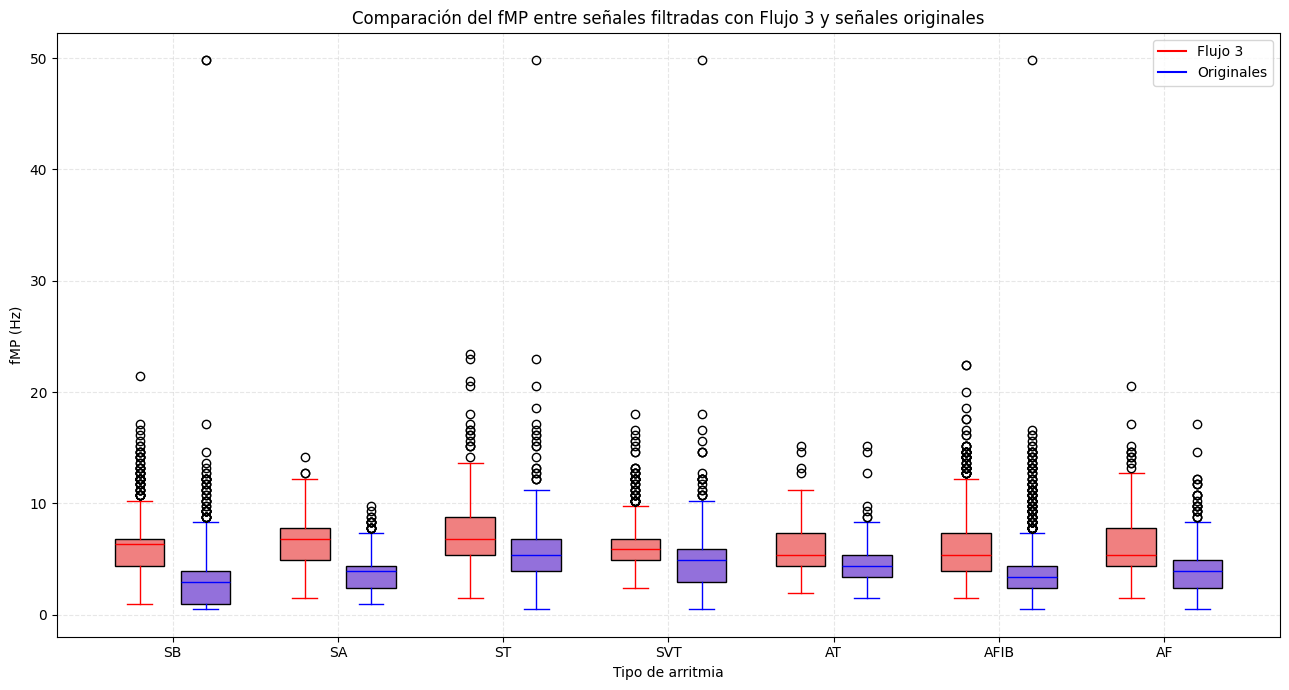

In [ ]:
tipos_arritmia = ['SB', 'SA', 'ST', 'SVT', 'AT', 'AFIB', 'AF']

fig, ax = plt.subplots(figsize=(13, 7))

# Posiciones en el eje x para cada boxplot
x = list(range(len(tipos_arritmia)))
offset = 0.2  # separación entre los dos boxplots

# Recolectar datos para graficar
datos_flujo3 = []
datos_filtrados = []

for tipo in tipos_arritmia:
    datos_flujo3.append(df_fmp_resultados_flujo3[df_fmp_resultados_flujo3['Rhythm'] == tipo]['fMP'].values)
    datos_filtrados.append(df_fmp_filtrados[df_fmp_filtrados['Rhythm'] == tipo]['fMP'].values)

# Boxplot para Flujo 3
bp1 = ax.boxplot(datos_flujo3, positions=[i - offset for i in x],
                 widths=0.3, patch_artist=True, boxprops=dict(facecolor='lightcoral'),
                 medianprops=dict(color='red'), whiskerprops=dict(color='red'), capprops=dict(color='red'))

# Boxplot para señales ya filtradas (originales)
bp2 = ax.boxplot(datos_filtrados, positions=[i + offset for i in x],
                 widths=0.3, patch_artist=True, boxprops=dict(facecolor='mediumpurple'),
                 medianprops=dict(color='blue'), whiskerprops=dict(color='blue'), capprops=dict(color='blue'))

# Eje x
ax.set_xticks(x)
ax.set_xticklabels(tipos_arritmia)
ax.set_xlabel("Tipo de arritmia")
ax.set_ylabel("fMP (Hz)")
ax.set_title("Comparación del fMP entre señales filtradas con Flujo 3 y señales originales")

# Leyenda
ax.plot([], c='red', label='Flujo 3')
ax.plot([], c='blue', label='Originales')
ax.legend()

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-21-3025790113.py:53: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='black'))
/tmp/ipython-input-21-3025790113.py:53: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='black'))


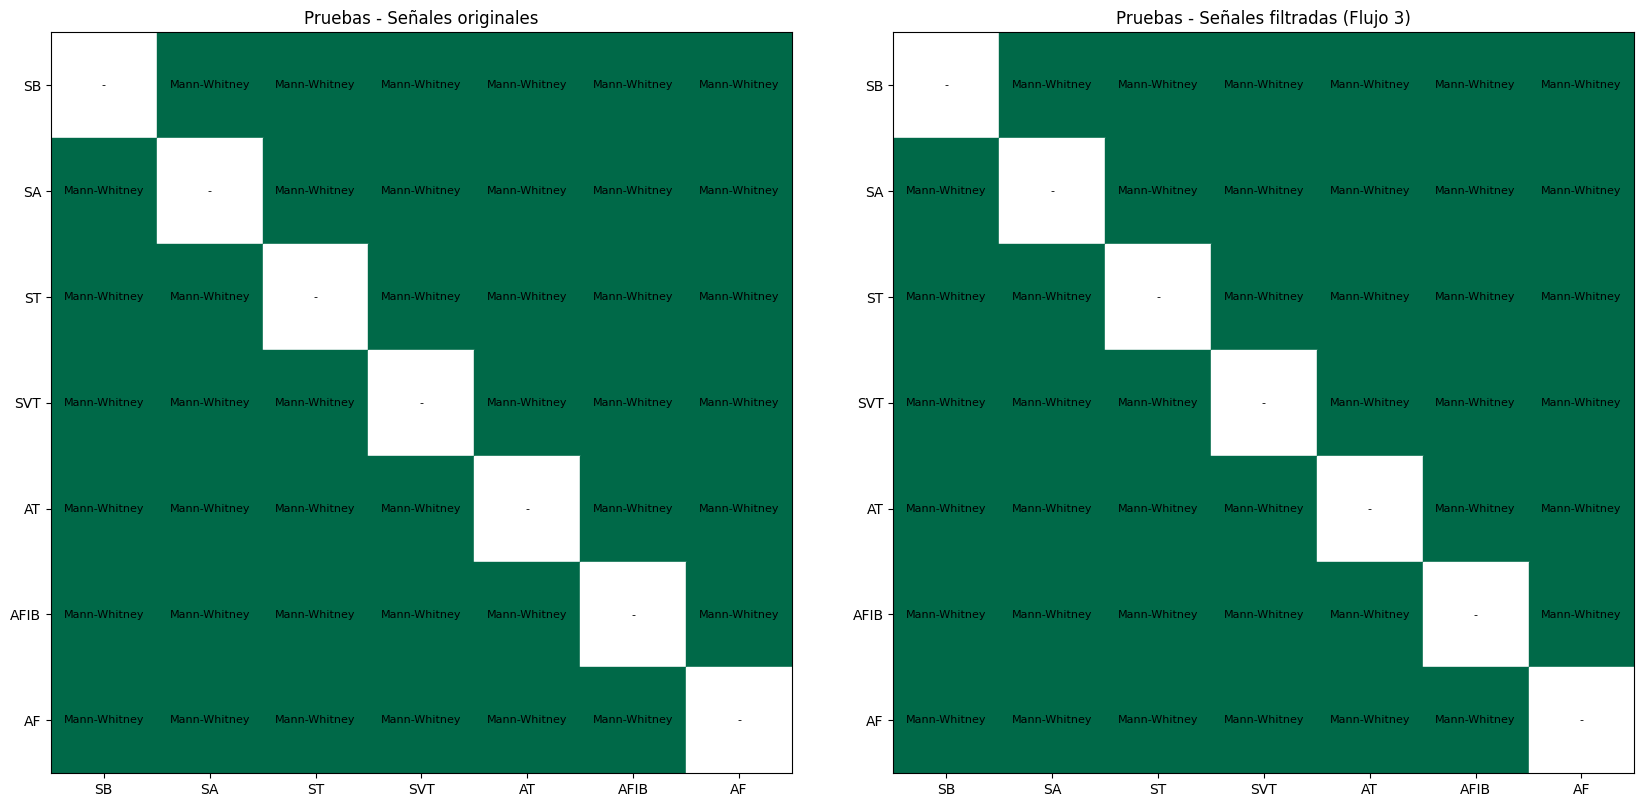

In [ ]:
# Función para determinar tipo de prueba entre dos pares de arritmias
def determinar_prueba(grupo1, grupo2, alpha=0.05):
    # Validación de normalidad
    _, p_norm1 = shapiro(grupo1)
    _, p_norm2 = shapiro(grupo2)
    normales = p_norm1 > alpha and p_norm2 > alpha

    # Validación de homocedasticidad (si normales)
    if normales:
        _, p_levene = levene(grupo1, grupo2)
        homocedasticas = p_levene > alpha
        if homocedasticas:
            return 't-Student'
    return 'Mann-Whitney'

# Función para crear matriz de tipo de prueba
def crear_matriz_tipo_prueba(df, nombre):
    arritmias = ['SB', 'SA', 'ST', 'SVT', 'AT', 'AFIB', 'AF']
    matriz = pd.DataFrame('', index=arritmias, columns=arritmias)
    for i in arritmias:
        for j in arritmias:
            if i == j:
                matriz.loc[i, j] = '-'
            else:
                datos_i = df[df['Rhythm'] == i]['fMP']
                datos_j = df[df['Rhythm'] == j]['fMP']
                if len(datos_i) > 3 and len(datos_j) > 3:
                    tipo = determinar_prueba(datos_i, datos_j)
                    matriz.loc[i, j] = tipo
                else:
                    matriz.loc[i, j] = 'n/a'
    return matriz

# Crear matrices para ambos DataFrames
matriz_original = crear_matriz_tipo_prueba(df_fmp_filtrados, 'Originales')
matriz_flujo3 = crear_matriz_tipo_prueba(df_fmp_resultados_flujo3, 'Flujo 3')

# Función para graficar matriz
def graficar_matriz(matriz, titulo, ax):
    arritmias = matriz.columns
    colores = matriz.replace({
        't-Student': 'red',
        'Mann-Whitney': '#006948',
        '-': 'white',
        'n/a': 'gray'
    })

    # Dibujar matriz con colores
    for i, fila in enumerate(arritmias):
        for j, col in enumerate(arritmias):
            valor = matriz.loc[fila, col]
            color = colores.loc[fila, col]
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='black'))
            ax.text(j + 0.5, i + 0.5, valor, ha='center', va='center', fontsize=8)

    ax.set_xticks(np.arange(len(arritmias)) + 0.5)
    ax.set_yticks(np.arange(len(arritmias)) + 0.5)
    ax.set_xticklabels(arritmias)
    ax.set_yticklabels(arritmias)
    ax.set_xlim(0, len(arritmias))
    ax.set_ylim(0, len(arritmias))
    ax.invert_yaxis()
    ax.set_title(titulo)
    ax.set_aspect('equal')
    ax.grid(False)

# Crear figura 1x2
fig, axes = plt.subplots(1, 2, figsize=(17, 8))

graficar_matriz(matriz_original, "Pruebas - Señales originales", axes[0])
graficar_matriz(matriz_flujo3, "Pruebas - Señales filtradas (Flujo 3)", axes[1])

plt.tight_layout()
plt.show()


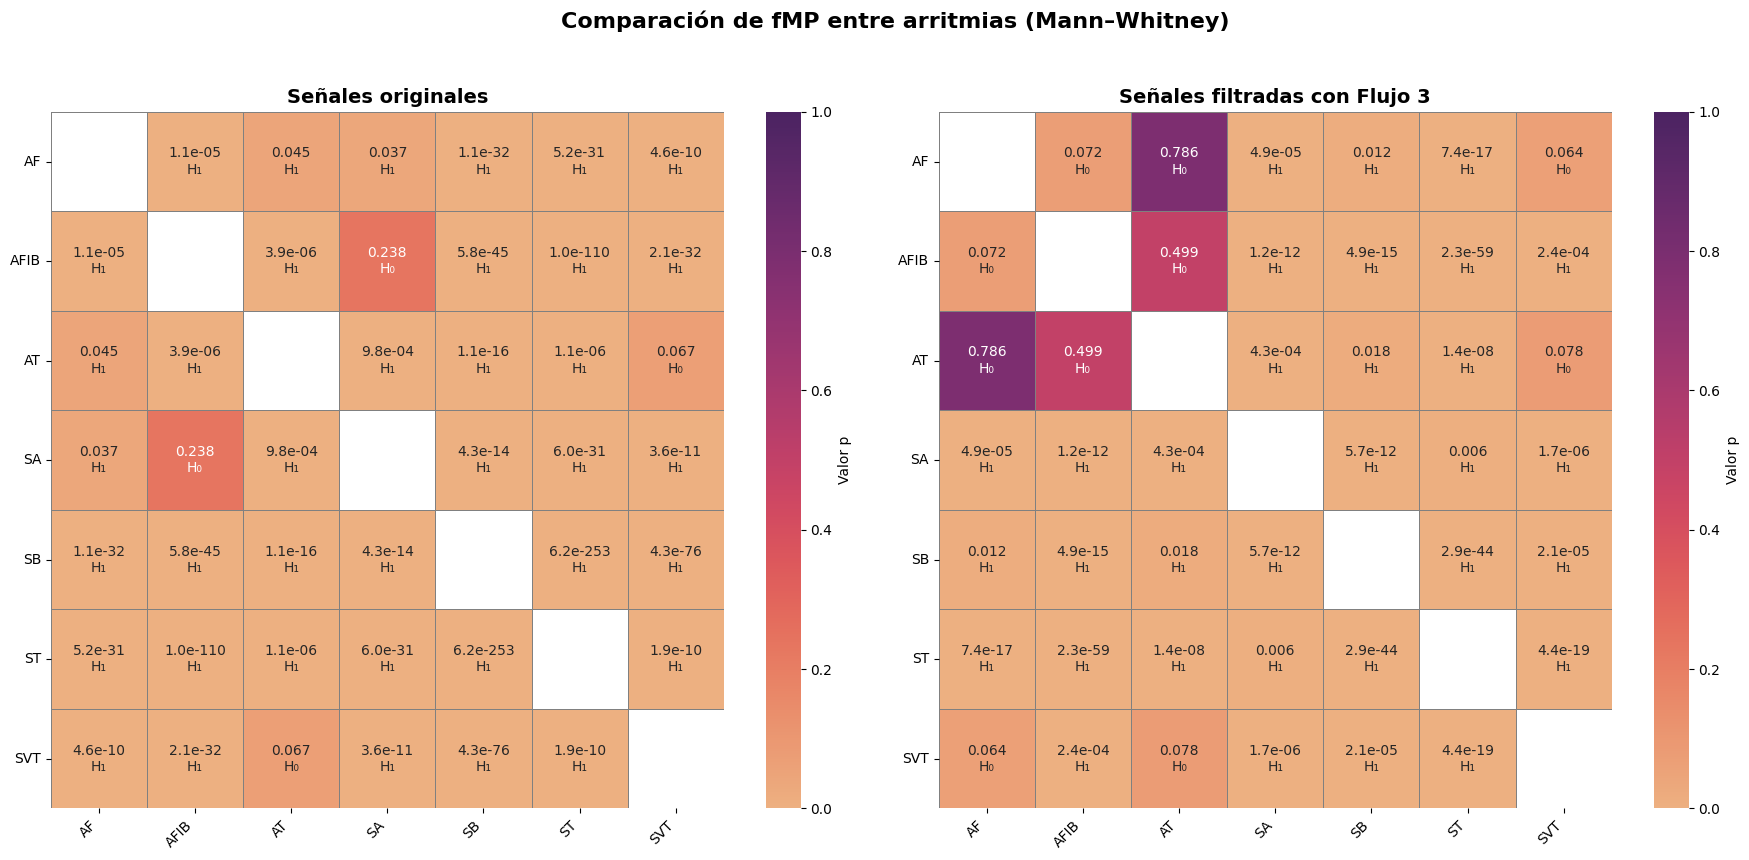

In [ ]:
def calcular_matriz_mannwhitney(df, alpha=0.05):
    tipos = sorted(df['Rhythm'].dropna().unique())
    matriz_texto = pd.DataFrame(index=tipos, columns=tipos)
    matriz_pval = pd.DataFrame(index=tipos, columns=tipos, dtype=float)
    p_values = []

    for r1, r2 in combinations(tipos, 2):
        grupo1 = df[df['Rhythm'] == r1]['fMP'].dropna()
        grupo2 = df[df['Rhythm'] == r2]['fMP'].dropna()

        if len(grupo1) >= 3 and len(grupo2) >= 3:
            p = mannwhitneyu(grupo1, grupo2, alternative='two-sided').pvalue
            decision = "H₁" if p < alpha else "H₀"
            texto = f"{p:.1e}\n{decision}" if p < 0.001 else f"{p:.3f}\n{decision}"
            p_values.append(p)
        else:
            p, texto = np.nan, "ND\nN/A"

        for a, b in [(r1, r2), (r2, r1)]:
            matriz_texto.loc[a, b] = texto
            matriz_pval.loc[a, b] = p

    np.fill_diagonal(matriz_pval.values, np.nan)
    np.fill_diagonal(matriz_texto.values, "—")

    # Resumen de métricas
    p_values = np.array(p_values)
    rechazadas = p_values[p_values < alpha]
    total_comparaciones = len(p_values)

    resumen = {
        'Comparaciones Significativas (%)': 100 * len(rechazadas) / total_comparaciones,
        'Promedio_pval_total': np.mean(p_values),
        'Promedio_pval_rechazadas': np.mean(rechazadas) if len(rechazadas) > 0 else np.nan,
        'Valor_p_min': np.min(p_values),
        'Valor_p_max': np.max(p_values)
    }

    return matriz_texto, matriz_pval, resumen

# Calcular para ambos conjuntos
texto1, pval1, resumen1 = calcular_matriz_mannwhitney(df_fmp_filtrados)
texto2, pval2, resumen2 = calcular_matriz_mannwhitney(df_fmp_resultados_flujo3)

# Crear tabla resumen
df_resumen = pd.DataFrame({
    'Señales originales': resumen1,
    'Señales filtradas Flujo 3': resumen2
}).T

def graficar_heatmaps(textos, pvalores, titulos):
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    cmap = sns.color_palette("flare", as_cmap=True)

    for ax, texto, pval, titulo in zip(axes, textos, pvalores, titulos):
        sns.heatmap(pval, mask=pval.isnull(), cmap=cmap, annot=texto.values, fmt='',
                    linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Valor p'}, vmin=0, vmax=1, ax=ax)
        ax.set_title(titulo, fontsize=14, fontweight='bold')
        ax.set_xticklabels(texto.columns, rotation=45, ha='right')
        ax.set_yticklabels(texto.index, rotation=0)

    plt.suptitle("Comparación de fMP entre arritmias (Mann–Whitney)", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

graficar_heatmaps(
    [texto1, texto2],
    [pval1, pval2],
    ["Señales originales", "Señales filtradas con Flujo 3"]
)

In [ ]:
# Mostrar tabla
print("\nTabla resumen de comparación entre conjuntos:\n")
display(df_resumen.round(4))


Tabla resumen de comparación entre conjuntos:



,Comparaciones Significativas (%),Promedio_pval_total,Promedio_pval_rechazadas,Valor_p_min,Valor_p_max
Señales originales,90.4762,0.0185,0.0044,0.0,0.2375
Señales filtradas Flujo 3,76.1905,0.0731,0.0023,0.0,0.7856
